In [1]:
from narx import NARX
import tensorflow as tf
import numpy as np
import random

import pandas as pd

## Import testing data for NARX

In [2]:
num_prev_inputs = 4
obs_size = 3
act_size = 1

In [3]:
doc = np.load('tmp/data/multiple_runs.npy')

def create_prev_inputs_array(x, num_prev_inputs):
    """Returns previous observations concatenated, previous actions concatenated, outputs"""
    prev_obs = []
    prev_act = []
    for i in range(0,201-1-num_prev_inputs):
        prev_obs.append(np.concatenate(x[0, i:i+num_prev_inputs+1], 0)) # observations
        prev_act.append(np.concatenate(x[1, i:i+num_prev_inputs+1], 0)) # actions
    
    previous_obs = np.concatenate(prev_obs,1)
    previous_act = np.concatenate(prev_act,1)
    next_observation = np.concatenate(x[[0],num_prev_inputs+1:][0],1)
    
    return previous_obs.transpose(), previous_act.transpose(), next_observation.transpose()

data = []
for i in range(len(doc)):
    session_log = doc[i].copy() 
    data.append(create_prev_inputs_array(session_log, num_prev_inputs))


In [4]:
print('Training data consists of ',len(data),' sessions')
print('Each session consists of ',len(data[0]),'records')
print('In each record there are ',len(data[0][0]),' time steps to consider')
print('The records are:\n\tprevious observations \t\tsize = ({})\n\tprevious actions\t\tsize = ({})\n\tnext observation\t\tsize = ({})'.format(
    data[0][0].shape[1],data[0][1].shape[1],data[0][2].shape[1]))


Training data consists of  6120  sessions
Each session consists of  3 records
In each record there are  196  time steps to consider
The records are:
	previous observations 		size = (15)
	previous actions		size = (5)
	next observation		size = (3)


In [5]:
prev_ob_data = np.concatenate([_[0] for _ in data])  # x_1
prev_act_data = np.concatenate([_[1] for _ in data])  # x_2

x_data = np.concatenate([prev_ob_data,prev_act_data],1)
y_data = np.concatenate([_[2] for _ in data])

## Normalize inputs and outputs!!

observations and actions need to be scaled to values between 1 and -1. as can be seen below the gym inputs vary from -8 to 8

In [6]:
print('x_data = max ',['{:.1f}'.format(_) for _ in np.max(x_data,0)],'\n\t min ',['{:.1f}'.format(_) for _ in np.min(x_data,0)])
print('y_data = max ',['{:.1f}'.format(_) for _ in np.max(y_data,0)],'\n\t min ',['{:.1f}'.format(_) for _ in np.max(y_data,0)])

x_data = max  ['1.0', '1.0', '8.0', '1.0', '1.0', '8.0', '1.0', '1.0', '8.0', '1.0', '1.0', '8.0', '1.0', '1.0', '8.0', '2.0', '2.0', '2.0', '2.0', '2.0'] 
	 min  ['-1.0', '-1.0', '-8.0', '-1.0', '-1.0', '-8.0', '-1.0', '-1.0', '-8.0', '-1.0', '-1.0', '-8.0', '-1.0', '-1.0', '-8.0', '-2.0', '-2.0', '-2.0', '-2.0', '-2.0']
y_data = max  ['1.0', '1.0', '8.0'] 
	 min  ['1.0', '1.0', '8.0']


In [7]:
x_data = x_data / [1,1,8,1,1,8,1,1,8,1,1,8,1,1,8,2,2,2,2,2]
y_data = y_data / [1,1,8]
print('x_data = max ',['{:.1f}'.format(_).format(_) for _ in np.max(x_data,0)],'\n\t min ',['{:.1f}'.format(_) for _ in np.min(x_data,0)])
print('y_data = max ',['{:.1f}'.format(_) for _ in np.max(y_data,0)],'\n\t min ',['{:.1f}'.format(_) for _ in np.max(y_data,0)])

x_data = max  ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0'] 
	 min  ['-1.0', '-1.0', '-1.0', '-1.0', '-1.0', '-1.0', '-1.0', '-1.0', '-1.0', '-1.0', '-1.0', '-1.0', '-1.0', '-1.0', '-1.0', '-1.0', '-1.0', '-1.0', '-1.0', '-1.0']
y_data = max  ['1.0', '1.0', '1.0'] 
	 min  ['1.0', '1.0', '1.0']


## Set up batch cross val
First set up test train split

In [8]:
total_data = 196*6120

_ = np.split(x_data,5)
x_train = np.concatenate(_[:4])
x_test = _[4]
_ = np.split(y_data,5)
y_train = np.concatenate(_[:4])
y_test = _[4]
assert len(x_train)+len(x_test) == total_data and len(y_train)+len(y_test) == total_data

In [9]:
batch_size = 48
total_train_data = len(x_train)
assert total_train_data % batch_size == 0
iterations = 408 #int(total_train_data / batch_size)   # 408.33 would be the amount of data collected over 100 iterations
train_shuffle = random.sample(range(total_train_data),total_train_data)
test_shuffle = random.sample(range(len(x_test)),len(x_test))
test_every = 4 # after how many train examples do you test?

train_loops = 4 # if this doubles so should test every

# assert iterations*batch_size*1.25 == total_data

# Model

In [10]:
tf.reset_default_graph()
x_1 = tf.placeholder(dtype=tf.float32,
                         shape=[1,obs_size],
                         name='x_1')
x_2 = tf.placeholder(dtype=tf.float32,
                         shape=[1,act_size],
                         name='x_2')
y = tf.placeholder(dtype=tf.float32,
                       shape=[None,obs_size],
                       name='y')

queue_size = num_prev_inputs + 1
learning_rate = 0.001
nn = NARX(x_1, x_2, y, queue_size, [dict(units=20, activation=tf.nn.tanh, use_bias=True),
                         dict(units=20, activation=tf.nn.tanh, use_bias=True)], learning_rate=learning_rate)


train_writer = tf.summary.FileWriter('tmp/tboard/shuffled_batch_train')
test_writer = tf.summary.FileWriter('tmp/tboard/shuffled_batch_test')

merged = tf.summary.merge_all()

# Train

In [11]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    train_writer.add_graph(sess.graph)
    test_writer.add_graph(sess.graph)
    
    for loops in range(train_loops):
        for i in range(iterations):
            #Set up batches
            start=i*batch_size
            fin =(i+1)*batch_size
            _batch = train_shuffle[start:fin]
            #Get batches for training/testing
            _x_0 = x_train[_batch,:]
            _y = y_train[_batch,:]
            
            #Training
            summary, _cost, pred, _ = sess.run([merged, nn.cost,nn.predict_spara,nn.optimizer],feed_dict={nn.x_0:_x_0, nn.y:_y})
            train_writer.add_summary(summary,i+(loops*iterations))
            
            #Testing (every 4 iterations)
            if (i+1) % test_every == 0:
                #Set up batches
                start= int((i+1)/test_every) * batch_size
                fin = (int((i+1)/test_every) + 1)*batch_size
                _batch = test_shuffle[start:fin]
                
                _x_0 = x_train[_batch,:]
                _y = y_train[_batch,:]
                summary, _cost, pred = sess.run([merged, nn.cost,nn.predict_spara],feed_dict={nn.x_0:_x_0, nn.y:_y})
                test_writer.add_summary(summary,i+(loops*iterations))
                
                
    train_writer.close()
    test_writer.close()
    print('done training')
    
    
    # Used to Display Example of network simulating a run of a simulation
    vis_true = []
    vis_pred = []
    
    for i in range(len(x_test)):
        y_vis_pred = sess.run(nn.predict_spara,feed_dict={nn.x_0:x_test[[i],:]})
        vis_pred.append(y_vis_pred.reshape(3))
        vis_true.append(y_test[i])
    
    
print('done')

done training
done


In [14]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
# train_writer.add_graph(sess.graph)
# test_writer.add_graph(sess.graph)

for loops in range(train_loops):
    for i in range(iterations):
        #Set up batches
        start=i*batch_size
        fin =(i+1)*batch_size
        _batch = train_shuffle[start:fin]
        #Get batches for training/testing
        _x_0 = x_train[_batch,:]
        _y = y_train[_batch,:]

        #Training
        summary, _cost, pred, _ = sess.run([merged, nn.cost,nn.predict_spara,nn.optimizer],feed_dict={nn.x_0:_x_0, nn.y:_y})
#         train_writer.add_summary(summary,i+(loops*iterations))

        #Testing (every 4 iterations)
        if (i+1) % test_every == 0:
            #Set up batches
            start= int((i+1)/test_every) * batch_size
            fin = (int((i+1)/test_every) + 1)*batch_size
            _batch = test_shuffle[start:fin]

            _x_0 = x_train[_batch,:]
            _y = y_train[_batch,:]
            summary, _cost, pred = sess.run([merged, nn.cost,nn.predict_spara],feed_dict={nn.x_0:_x_0, nn.y:_y})
#             test_writer.add_summary(summary,i+(loops*iterations))


# train_writer.close()
# test_writer.close()
print('done training')

done training


In [28]:
_,_ = sess.run(nn.reset())

In [26]:
starting_point = data[0][2][[0],:]

array([[-0.9825136 ,  0.18619075,  0.28126308]], dtype=float32)

In [33]:
starting_ob = data[0][2][[0],:]
motor = np.array([0])[None]

In [ ]:
# Used to Display Example of network simulating a run of a simulation
vis_true = np.zeros([3,201])


for i in range(len(x_test)):
    _ = sess.run(nn.enqueue,feed_dict={nn.x_1:starting_ob, nn.x_2:motor })
    y_vis_pred = sess.run(nn.predict_spara,feed_dict={nn.x_0:x_test[[i],:]})
    vis_pred.append(y_vis_pred.reshape(3))
    vis_true.append(y_test[i])
    
    
print('done')

In [ ]:
print(len(vis_true)/196)
print(vis_pred[1].reshape(3))

In [14]:
import matplotlib.pyplot as plt
def plot_predicted_vs_original(pred,orig, title=None,xlabel='time',ylabel='out'):
    # Plot inputs
    # y0
    plt.title('cos(theta)')
    plt.plot([_ for _ in range(len(pred))],[_[0] for _ in pred],'-',label='pred',linewidth=3)
    plt.plot([_ for _ in range(len(orig))],[_[0] for _ in orig],'-',label='orig')
    if title: plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.legend(loc=4)
    plt.savefig('tmp/images/costheta.png', dpi=300,bbox_inches='tight',transparent=True, linewidth=4)
    plt.show()
    
    #y1
    plt.title('sin(theta)')
    plt.plot([_ for _ in range(len(pred))],[_[1] for _ in pred],'-',label='pred',linewidth=3)
    plt.plot([_ for _ in range(len(orig))],[_[1] for _ in orig],'-',label='orig')
    if title: plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.legend(loc=4)
    plt.savefig('tmp/images/sintheta.png', dpi=300,bbox_inches='tight',transparent=True,linewidth=4)
    plt.show()
    
    #y2
    plt.title('theta dot')
    plt.plot([_ for _ in range(len(pred))],[_[2]*8 for _ in pred],'-',label='pred',linewidth=3)
    plt.plot([_ for _ in range(len(orig))],[_[2]*8 for _ in orig],'-',label='orig')
    if title: plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.legend(loc=4)
    plt.savefig('tmp/images/thetadot.png', dpi=300,bbox_inches='tight',transparent=True)
    plt.show()

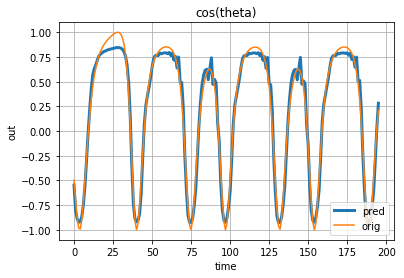

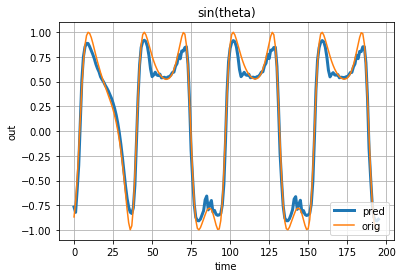

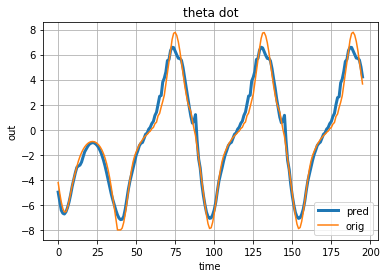

In [16]:
cycle=1006
start=196*cycle
fin=start+196
plot_predicted_vs_original(vis_pred[start:fin],vis_true[start:fin])

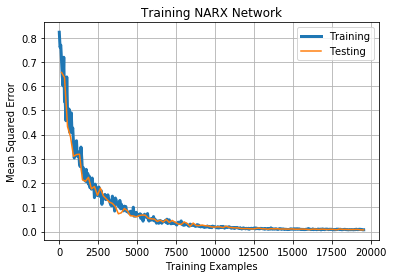

In [23]:
train = pd.read_csv('tmp/data/run_shuffled_batch_train-tag-cost_mean_squared_error_1.csv')
test = pd.read_csv('tmp/data/run_shuffled_batch_test-tag-cost_mean_squared_error_1.csv')

def plot_learning_curve(x_tr,y_tr, x_ts, y_ts, title="Training NARX Network",xlabel='Training Examples',ylabel='Mean Squared Error'):
    # Plot inputs
    plt.plot(x_tr*48,y_tr,'-',label='Training',linewidth=3)
    plt.plot(x_ts*48,y_ts,'-',label='Testing')

    
    if title: plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.legend()
    plt.savefig('tmp/images/training_narx.png', dpi=300,bbox_inches='tight',transparent=True)
#         facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None)
    plt.show()

plot_learning_curve(train['Step'],train['Value'],test['Step'],test['Value'])

In [24]:
test.head(5)

,Wall time,Step,Value
0,1.521646e+09,3,0.656726
1,1.521646e+09,7,0.635468
2,1.521646e+09,11,0.432930
3,1.521646e+09,15,0.390911
4,1.521646e+09,19,0.310664
